# Predicting Bike Rentals

A bike rental business rents out bicycles for short periods of time, usually for a few hours. Bicycle rental shop primarily serve people who don't have access to a vehicle, tipically travellers and particularly tourists. Most rentals are provided by bike shops as a sideline to their main business of sales and service, but some shops specialize in rentals.

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The district collects detailed data on the number of bicycles people rent by the hour and day.

In this project, we'll try to predict the total number of bikes people rented in a given hour. To accomplish this, we'll create a few different machine learning models and evaluate their performance. When possible we'll be using a fixed seed for random algorithms to make the test reproducible.

## Introduction to the Data Set

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which we'll use in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

These are the descriptions for all the columns :

* *instant* - A unique sequential ID number for each row
* *dteday* - The date of the rentals
* *season* - The season in which the rentals occurred
* *yr* - The year the rentals occurred
* *mnth* - The month the rentals occurred
* *hr* - The hour the rentals occurred
* *holiday* - Whether or not the day was a holiday
* *weekday* - The day of the week (as a number, 0 to 7)
* *workingday* - Whether or not the day was a working day
* *weathersit* - The weather (as a categorical variable)
* *temp* - The temperature, on a 0-1 scale
* *atemp* - The adjusted temperature
* *hum* - The humidity, on a 0-1 scale
* *windspeed* - The wind speed, on a 0-1 scale
* *casual* - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* *registered* - The number of registered riders (people who had already signed up)
* *cnt* - The total number of bike rentals (*casual* + *registered*)

Let's have a look at the data.

In [2]:
#Importing the library
import pandas as pd

#Reading the data into a dataframe
bike_rentals = pd.read_csv("bike_rental_hour.csv")

#Showing some info about the dataframe
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [3]:
#Showing some rows of the dataframe
bike_rentals.head(4)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13


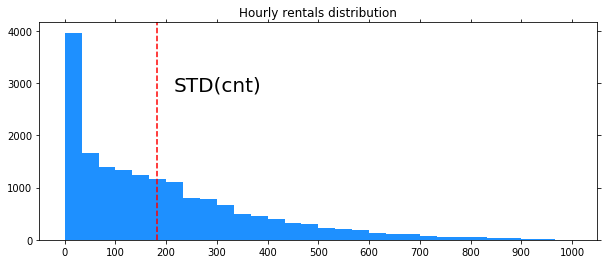

In [4]:
#Importing the libraries
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#Building the plot for the hourly rental distribution
plt.figure(figsize=(10,4))
plt.hist(bike_rentals["cnt"], bins=30, range=(0,1000), color="dodgerblue")
x_ticks = np.linspace(0, 1000, 11)
y_ticks = np.linspace(0, 4000, 5)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.tick_params(top="off", right="off")
plt.title("Hourly rentals distribution")

#Showing the standard deviation in the plot
cnt_std = bike_rentals["cnt"].std()
plt.axvline(cnt_std, linestyle="--", color="red")
plt.text(215, 2850, "STD(cnt)", size=20)
plt.show()

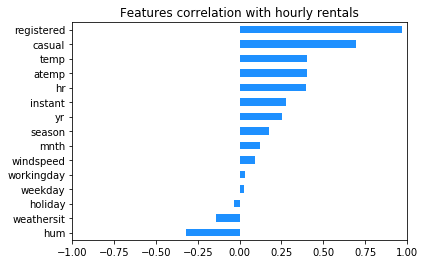

In [5]:
#Building the plot for the correlations with hourly rentals 
bike_rentals.corr()["cnt"].sort_values()[:-1].plot(kind="barh", title="Features correlation with hourly rentals", color="dodgerblue")
plt.xlim(-1,1)
plt.show()

## Calculating Features

We'll calculate some features before applying machine learning models. It can enhance the accuracy of models by introducting new information, or distilling existing information.

For example, the *hr* column contains the hours during which bikes are rented, from 1 to 24. A mchine learning will treat each hour differently without undestanding that certain hours are related. So we'll introduce some order into process by creating a new column with labels for *morning*, *afternoon*, *evening* and *night*. This will merge similar times together, enabling the model to make better decisions.

In [6]:
#Writing the function to group the hours
def assign_label(hour):
    label = 0
    if hour >= 6 and hour < 12:
        label = 1
    if hour >= 12 and hour < 18:
        label = 2
    elif hour >= 18 and hour < 24:
        label = 3
    elif hour >= 0 and hour < 6:
        label = 4
    return label   

#Applying the function to the interested column
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

## Splitting the Data into Train and Test Set

Before applying machine learning algorithms, we'll need to split the data into training and testing sets. This will enable us to train an algorithm using the training set and evaluate its accuracy on the testing set. This is the right practice, if we train an algorithm on the training data and then evaluate its performance on the same data, we'll get an unrealistically low error due to overfitting.

### Choosing the Error Metric
Now we have to choose a metric that quantifies how good the prediction on the test set are.
For a regression task the most used metrics are: 

* **Root Mean Squared Error** - RMSE is the square root of the average squared differences between the target value and the value predicted by the model. It's preferred more in some cases because the errors are first squared before averaging which poses a high penalty on large errors. This implies that RMSE is useful when a large errors are undesired.

* **Mean Absolute Error** - MAE is the absolute difference between the target value and the value predicted by the model. It's more robust to outliers and doesn't penalize the errors as extremely as RMSE, all the individual differences are weighted equally. It's not suitable for applications where you want to pay more attention to the outliers.

We choose the RMSE as the error metric since we want to penalize large errors.

In [7]:
#Training set
train = bike_rentals.sample(frac=.8, random_state=1)

#Testing set
train_indices = train.index
test = bike_rentals.drop(train_indices)

#Checking the number of the rows
print("{} rows for the training set\n{} rows for the testing set".format(len(train), len(test)))

13903 rows for the training set
3476 rows for the testing set


## Filtering Features

Now we'll create a list of predictor columns to use in training and predictions. For example we'll need to ignore the *casual* and *registered* columns because our target column *cnt* is derived from them. If we're trying to predict the number of people who rent bikes in a given hour, it doesn't make sense that you'd already know *casual* and *registered*, because those numbers are added together to get *cnt*. We'll remove the *dteday* as well, since it isn't a numerical column and isn't useful for our aim.

In [8]:
#Creating the list of the useful columns
features = bike_rentals.columns
features = features.drop(["cnt", "casual", "registered", "dteday"])
features

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

Let's check whether there are columns that have a correlation near to 1. In this case, we'll remove these columns since they have almost the same information.

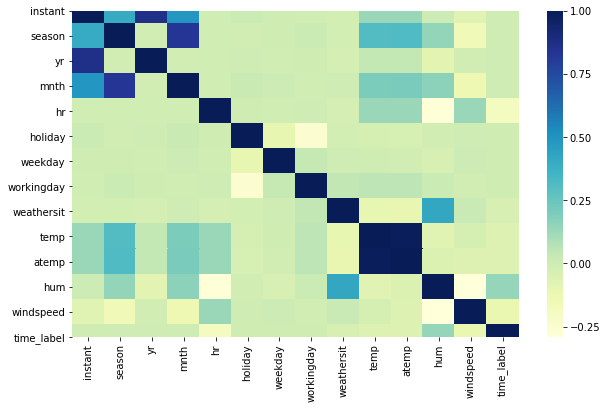

In [9]:
#Importing the library
import seaborn as sns

#Showing the correlation between the columns through a heatmap
corr = bike_rentals[features].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="YlGnBu")

In [10]:
#Checking the correlation between temp and atemp columns
bike_rentals["temp"].corr(bike_rentals["atemp"])

0.9876721390396483

In [11]:
#Dropping the temp column
features = features.drop(["temp"])

We've removed the *temp* column because it's almost equal to the *atemp* column, since they have a correlation of 0.987, and would have altered the results. Last thing we'll do is to keeping as features only columns with a high correlation with our target column, we'll use a treshold of 0.30.

In [12]:
#Computing the correlation of all the columns with our target column
correlations = bike_rentals.corr()["cnt"][features].sort_values(ascending=False)
correlations

atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

In [13]:
#Filtering the columns with a certain correlation
treshold = .3
good_corr = correlations[(correlations>treshold) | (correlations<-treshold)]
good_corr

atemp         0.400929
hr            0.394071
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

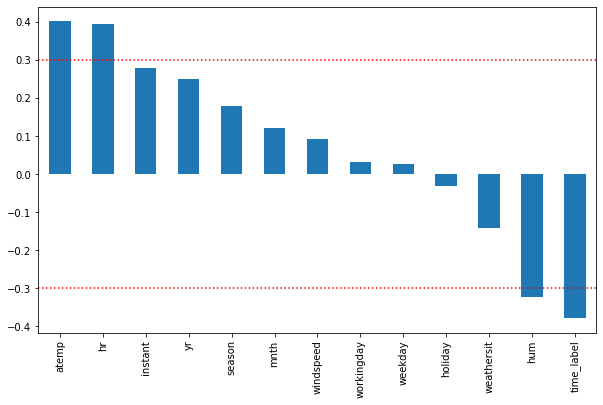

In [14]:
#Showing the result in a plot
ax = correlations.plot.bar(figsize=(10,6))
ax.axhline(treshold, c="r", linestyle="dotted")
ax.axhline(-treshold, c="r", linestyle="dotted")

In [15]:
#Selecting columns to drop
to_drop = correlations[(correlations<=treshold) & (correlations>=-treshold)]
to_drop = to_drop.index.values

#Updating the features list
filtered_features = features.drop(to_drop)
filtered_features

Index(['hr', 'atemp', 'hum', 'time_label'], dtype='object')

## Linear Regression

Now that we've done some exploration and manipulation, we're ready to apply linear regression to the data. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data and not building a powerful enough model. This means that linear regression usually isn't the most accurate option. However let's check the accuracy of the model.

In [16]:
#Importing libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Testing the model with all the features
lr = LinearRegression()
lr.fit(train[features], train["cnt"])
predictions = lr.predict(test[features])
mse = mean_squared_error(test["cnt"], predictions)
rmse = np.sqrt(mse)
print(rmse)

130.59675246155683


In [17]:
#Testing the model with features with more than 0.30 correlation
lr.fit(train[filtered_features], train["cnt"])
predictions = lr.predict(test[filtered_features])
mse = mean_squared_error(test["cnt"], predictions)
rmse = np.sqrt(mse)
print(rmse)

137.04860768382468


### Considerations

The error is very high, which may be to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. The test with the filtered features shows that there is no improvement, the model performs even slightly worse.

## Decision Tree

Now we are ready to apply the decision tree algorithm. We'll be able to compare its error with the error from linear regression, which will enable us to pick the rightalgorithm for this data set. Decision trees tend to predict outcomes much more reliably than linear regression models because a decision tree is a quite complex model, it also tend to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. We'll make several attempts to find the parameters that allow us to minimize the error.

In [18]:
#Importing the library
from sklearn.tree import DecisionTreeRegressor

#Testing the model with all the features and default parameters
dt = DecisionTreeRegressor(random_state=1)
dt.fit(train[features], train["cnt"])
predictions = dt.predict(test[features])
mse = mean_squared_error(test["cnt"], predictions)
rmse = np.sqrt(mse)
print(rmse)

56.684290113616974


In [19]:
#Tuning parameters
dt_rmse_values = {}
for n in range(1, 25):
    for m in range (2, 25):
        dt = DecisionTreeRegressor(min_samples_leaf=n, min_samples_split=m, random_state=1)
        dt.fit(train[features], train["cnt"])
        predictions = dt.predict(test[features])
        mse = mean_squared_error(test["cnt"], predictions)
        rmse = np.sqrt(mse)
        dt_rmse_values[(n, m)] = rmse

In [20]:
#Displaying the best parameters combination
print("The best parameters combination is:\nmin_sample_leaf: {}\nmin_sample_split: {}"
      .format(min(dt_rmse_values, key=dt_rmse_values.get)[0], min(dt_rmse_values, key=dt_rmse_values.get)[1]))

The best parameters combination is:
min_sample_leaf: 7
min_sample_split: 2


In [21]:
#Showing the corresponding rmse
print("The corrisponding rmse is:\n{}".format(dt_rmse_values[7,2]))

The corrisponding rmse is:
51.12427549953015


Now we'll make the same test but only using the features with a correlation higher than 0.30 with our target column, and we'll see whether there is an improvement.

In [22]:
#Testing the model with all the features with a correlation higher than 0.30 and default parameters
dt = DecisionTreeRegressor(random_state=1)
dt.fit(train[filtered_features], train["cnt"])
predictions = dt.predict(test[filtered_features])
mse = mean_squared_error(test["cnt"], predictions)
rmse = np.sqrt(mse)
print(rmse)

133.61365037630435


In [23]:
#Tuning parameters
dt2_rmse_values = {}
for n in range(1, 25):
    for m in range (2, 25):
        dt = DecisionTreeRegressor(min_samples_leaf=n, min_samples_split=m, random_state=1)
        dt.fit(train[filtered_features], train["cnt"])
        predictions = dt.predict(test[filtered_features])
        mse = mean_squared_error(test["cnt"], predictions)
        rmse = np.sqrt(mse)
        dt2_rmse_values[(n, m)] = rmse

In [24]:
#Displaying the best parameters combination
print("The best parameters combination is:\nmin_sample_leaf: {}\nmin_sample_split: {}"
      .format(min(dt2_rmse_values, key=dt2_rmse_values.get)[0], min(dt2_rmse_values, key=dt2_rmse_values.get)[1]))

The best parameters combination is:
min_sample_leaf: 24
min_sample_split: 2


In [25]:
#Showing the corresponding rmse
print("The corrisponding rmse is:\n{}".format(dt2_rmse_values[7,2]))

The corrisponding rmse is:
110.67942736402888


### Considerations

As expected, the decision tree regressor appears to have much higher accuracy than linear regression.
It lowered the RMSE from 130.6 to 56.7 using default parameters. We have optimized the *min_samples_leaf* and the *min_samples_split* parameters obtaining a RMSE of 51.1 in the best case. We have also tested the same process with a filtered list of features, we have selected only the features with a correlation higher than 0.30 with our target column, but the RMSE has increased significantly to 110.7 after the parametrs optmization.

## Random Forest

We can now apply the random forest algorithm, which improves the decision tree algorithm. Random forests tend to be much more accurate than simple models. Due to the way random forests are constructed, they tend to overfit much less than decision trees. We'll tune parameters to obtain the optimal RMSE value. 

In [34]:
#Importing the library
from sklearn.ensemble import RandomForestRegressor

#Testing the model with all the features and default parameters
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(train[features], train["cnt"])
predictions = rf.predict(test[features])
mse = mean_squared_error(test["cnt"], predictions)
rmse = np.sqrt(mse)
print(rmse)

45.84289985596114


Let's make the same test using the features with a correlation higher than 0.30 with our target column, and let's see whether the rmse goes down.

In [27]:
#Testing the model with the features with a correlation higher than 0.30 with our target column
# and default parameters
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(train[filtered_features], train["cnt"])
predictions = rf.predict(test[filtered_features])
mse = mean_squared_error(test["cnt"], predictions)
rmse = np.sqrt(mse)
print(rmse)

118.43441299799866


Using only the high correlated columns doesn't let us make any progress, on the contrary, the rmse went up a lot. So we'll continue to work with all the features.

In [28]:
#Finding the best number of trees in the forest
rf_rmse_values = {}
space = np.logspace(1, 2.2, 30, dtype=int)
for n in space:
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(train[features], train["cnt"])
    predictions = rf.predict(test[features])
    mse = mean_squared_error(test["cnt"], predictions)
    rmse = np.sqrt(mse)
    rf_rmse_values[n] = rmse
rf_rmse_values

{10: 45.84289985596114,
 12: 45.464980961512694,
 13: 45.05750017120703,
 14: 44.988857778536385,
 16: 44.761472986411675,
 17: 44.704166997448745,
 19: 44.48640278916543,
 21: 44.610201006541025,
 23: 44.20455348549973,
 25: 43.89838544729375,
 28: 44.0364166650316,
 31: 43.925731792518796,
 34: 43.75828455845062,
 37: 43.689752866497315,
 41: 43.58363518570583,
 45: 43.5038235240452,
 50: 43.40266048094213,
 55: 43.44639354010382,
 61: 43.23418762921946,
 67: 43.2342617993008,
 73: 43.19635627381733,
 81: 43.189834733412646,
 89: 43.06500226813072,
 98: 43.043986188683526,
 108: 42.929693178777136,
 119: 42.848777767931445,
 130: 42.83284012108941,
 144: 42.7918749818685,
 158: 42.83751399872483}

In [37]:
#Showing the best result
print("Number of trees:{}\nRMSE: {}"
      .format(min(rf_rmse_values, key=rf_rmse_values.get), min(rf_rmse_values.values())))

Number of trees:(1, 2)
RMSE: 42.7918749818685


Now we'll tune the parameters to try to improve the minimum actual rmse score.

In [30]:
#Tuning the parameters
rf2_rmse_values = {}
for n in space:
    rf = RandomForestRegressor(n_estimators=n, min_samples_leaf=3, random_state=1)
    rf.fit(train[features], train["cnt"])
    predictions = rf.predict(test[features])
    mse = mean_squared_error(test["cnt"], predictions)
    rmse = np.sqrt(mse)
    rf2_rmse_values[n] = rmse

In [31]:
#Showing the result
rf2_rmse_values

{10: 45.77007623748343,
 12: 45.71740324823514,
 13: 45.32665712000087,
 14: 45.20087608046627,
 16: 44.99216972996931,
 17: 45.01658404041422,
 19: 45.073785146964646,
 21: 45.25272345167756,
 23: 45.09835042115734,
 25: 44.937158146825496,
 28: 45.03319572899079,
 31: 44.810280951227874,
 34: 44.66089060246279,
 37: 44.55138368661831,
 41: 44.561728470793476,
 45: 44.48264029037175,
 50: 44.411700924851544,
 55: 44.47261550079121,
 61: 44.39643301933231,
 67: 44.43164805220793,
 73: 44.44856564008155,
 81: 44.382120375528324,
 89: 44.335645051107,
 98: 44.26733879311033,
 108: 44.207801717058075,
 119: 44.13833813752492,
 130: 44.14572072660932,
 144: 44.05544259999068,
 158: 44.04494240202518}

In [32]:
#Tuning the parameters
rf3_rmse_values = {}
for n in range(1, 5):
    for m in range(2, 5):
        rf = RandomForestRegressor(n_estimators=144, min_samples_leaf=n, min_samples_split=m, random_state=1)
        rf.fit(train[features], train["cnt"])
        predictions = rf.predict(test[features])
        mse = mean_squared_error(test["cnt"], predictions)
        rmse = np.sqrt(mse)
        rf3_rmse_values[(n, m)] = rmse

In [33]:
#Showing the result
rf3_rmse_values

{(1, 2): 42.7918749818685,
 (1, 3): 42.93522519798766,
 (1, 4): 43.04650968751081,
 (2, 2): 43.25814548595932,
 (2, 3): 43.25814548595932,
 (2, 4): 43.25814548595932,
 (3, 2): 44.05544259999068,
 (3, 3): 44.05544259999068,
 (3, 4): 44.05544259999068,
 (4, 2): 44.71590671167019,
 (4, 3): 44.71590671167019,
 (4, 4): 44.71590671167019}

### Considerations

As expected, random forest decreases the RMSE value from 56.7 to 45.8 using 10 estimators which is the default value in scikit learn version 0.20. We've tried to increase the number of estimators parameter and we found that generally RMSE decrease as the number of trees in the random forest increase. With 144 estimators we found our best result with a RMSE of 42.79, we can also increase the number of estimator still more to see if the RMSE continues to fall or begins to increase. We've also tried to change some parameters but we haven't found any combinations that has improved our result.

## Conclusion

In this project we have created 3 machine learning models to achieve our goal. Here are the results (best case):

* **Linear Regression** = 130.60 (RMSE)
* **Decision Tree** = 51.12 (RMSE)
* **Random Forest** = 42.79 (RMSE)

As expected, the linear model has had very bad results, the decision tree model has greatly improved the error and even better work has been done by random forest. Random forest is a kind of ensemble model and combining the predictions of multiple decision trees has allowed us to improve the results.
We can note that, in all three models, when we decided to train the model on a filtered set of features(those that have a correlation greater than 0.30 with our target column) the RMSE increased a lot.